<a href="https://colab.research.google.com/github/ev1025/SNS_Marketer/blob/main/%EB%8F%84%EC%84%9C%EA%B4%80%EB%A6%AC%EB%B7%B0_%ED%81%AC%EB%A1%A4%EB%A7%81_%EC%9B%8C%EB%93%9C%ED%81%B4%EB%9D%BC%EC%9A%B0%EB%93%9C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install BeautifulSoup4

In [ ]:
!pip install selenium
!apt-get update
!apt install chromium-chromedriver
!cp /usr/lib/chromium-browser/chromedriver /usr/bin

In [77]:
pip install konlpy

In [78]:
!apt-get update -qq
!apt-get install fonts-nanum* -qq

In [90]:
from bs4 import BeautifulSoup
import requests
import time
import pandas as pd
import numpy as np
import csv

from wordcloud import WordCloud
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from collections import Counter
from konlpy.tag import Okt
from PIL import Image

from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver import ActionChains

ModuleNotFoundError: ignored

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# 크롬 실행
driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()))
# 사이트 방문
driver.get('https://play.google.com/store/games?hl=ko-KR')

# 찾을 목록
search_list = ["서울도서관", "밀리의 서재"]
for search in search_list:
    search_button = driver.find_element(By.CSS_SELECTOR, '#kO001e > header > nav > div > div:nth-child(1) > button')
    search_button.send_keys(Keys.ENTER)

    # 검색상자 찾기
    search_box = driver.find_element(By.CSS_SELECTOR, '#kO001e > header > nav > c-wiz > div > div > label > input')

    # 검색어 입력
    search_box.send_keys(f'{search}')
    search_box.send_keys(Keys.ENTER)
    time.sleep(3)

    # 앱박스 가기
    app_box = driver.find_element(By.CSS_SELECTOR, '#yDmH0d > c-wiz:nth-child(7) > div > div > c-wiz > c-wiz:nth-child(1) > c-wiz > section > div > div > a')
    app_box.send_keys(Keys.ENTER)
    time.sleep(3)

    # 스크롤 내리기
    last_height = driver.execute_script("return document.body.scrollHeight")
    while True:
        # 아래코드는 자바스크립트의 scroll 함수를 사용하기 위해 자바스크립트 코드를 web driver에게 전달
        # 자바스크립트 코드의 기능 -> 끝까지 스크롤 다운
        driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
        time.sleep(2)

        # 스크롤 다운 후 스크롤 높이 다시 가져옴
        new_height = driver.execute_script("return document.body.scrollHeight")

        # 이전 height와 새로운 height와 같으면 탈출
        # 스크롤 할때마다 전체 height가 커지기 때문에 이전 height와 같다는 뜻은 더 이상 스크롤이 없다는 뜻
        if new_height == last_height:
            break
        last_height = new_height

    driver.find_element(By.CSS_SELECTOR,'body').send_keys(Keys.PAGE_UP)
    time.sleep(2)

    # 모든 리뷰
    all_review = driver.find_element(By.CSS_SELECTOR, "#yDmH0d > c-wiz.SSPGKf.Czez9d > div > div > div.tU8Y5c > div.wkMJlb.YWi3ub > div > div.qZmL0 > div:nth-child(1) > c-wiz:nth-child(4) > section > div > div.Jwxk6d > div:nth-child(5) > div > div > button > span")
    all_review.click()
    time.sleep(1)

    # 리뷰창 누르기
    review_box = driver.find_element(By.CSS_SELECTOR, "#yDmH0d > div.VfPpkd-Sx9Kwc.cC1eCc.UDxLd.PzCPDd.HQdjr.VfPpkd-Sx9Kwc-OWXEXe-FNFY6c > div.VfPpkd-wzTsW > div > div > div > div > div.fysCi > div > div:nth-child(2)")
    review_box.click()

    # 스크롤 전 리뷰 수 기록
    first_re = driver.find_elements(By.CSS_SELECTOR,'div.X5PpBb')

    # 스크롤 전 리뷰 수와 스크롤 후 리뷰 수가 같을 때 까지 스크롤링
    while True:
        # 스크롤 내리기
        driver.find_element(By.CSS_SELECTOR, "body").send_keys(Keys.END)
        driver.find_element(By.CSS_SELECTOR, "body").send_keys(Keys.END)
        driver.find_element(By.CSS_SELECTOR, "body").send_keys(Keys.END)
        driver.find_element(By.CSS_SELECTOR, "body").send_keys(Keys.END)
        driver.find_element(By.CSS_SELECTOR, "body").send_keys(Keys.END)

        # 스크롤 후 리뷰 수 세기
        second_re = driver.find_elements(By.CSS_SELECTOR,'div.X5PpBb')
        print(len(first_re),len(second_re))

        # 스크롤 후 리뷰 수가 같다면 멈추기
        if first_re == second_re:
            break
        # 다음 비교를 위해 갱신
        first_re = second_re
        time.sleep(0.5)


    # 리뷰를 크롤링 하기 위해 영역을 설정해주기
    reviews = "document.querySelector('div.jgIq1').innerHTML"
    page_raw = driver.execute_script("return " + reviews)
    page_html = BeautifulSoup(page_raw, 'html.parser')

    # 리뷰 데이터 모두 리스트 형태로 저장
    date_list = page_html.select('span.bp9Aid')
    like_list = page_html.select('div.AJTPZc')
    review_list = page_html.select('div.h3YV2d')

    # like_list의 값을 숫자만 가져오기 ('사용자 중 5명이 좋아합니다' => '5')
    def only_int(like):
        num = re.sub(r"[^0-9]", "", like.text)
        return num

    # csv저장
    f = open(f'{search}_리뷰.csv', 'w', encoding='utf-8-sig', newline='')
    csvwriter = csv.writer(f)

    # 컬럼명
    col_name = ['날짜','좋아요 수', '리뷰']
    csvwriter.writerow(col_name)

    # 하나의 리스트에 같이 들어있어야 하는데 3컬럼으로 따로 나뉘어 있어서 따로 넣어주는 작업
    for a, b, c in zip(date_list, like_list, review_list):
        csvwriter.writerow([a.text, only_int(b), c.text])
    f.close()
    driver.get('https://play.google.com/store/games?hl=ko-KR')

driver.close()

43 123
123 190
190 190
43 123
123 243
243 363
363 483
483 683
683 803
803 1003
1003 1243
1243 1403
1403 1643
1643 1803
1803 2003
2003 2203
2203 2443
2443 2563
2563 2563


In [82]:
a = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/서울도서관_리뷰.csv')

# 리뷰 단어별로 자르기
review = a['리뷰'].str.split(' ')

# 첫번째 리뷰 단어 개수
first_review = len(review[0])
max_num = 0

# 단어가 제일 많은 리뷰 수
for i in review:
    if first_review  < len(i):
        max_num = len(i)

print(max_num)

83


In [83]:
# 컬럼별 단어 자르기
for i in range(max_num):
    a[i] = review.str[i]

In [84]:
# b에 단어들 저장하기
b = a.iloc[:,3:50]

In [85]:
# 단어들 한 컬럼(c)에 넣기
c= pd.DataFrame()
for i in range(max(b.columns)):
    c = pd.concat([c,b[i]])

c = c.dropna(axis=0)
# c.to_csv('워드클라우드.csv',index=False)

In [86]:
# 리스트에 넣기
abc = []
for i in range(len(c)):
    abc.extend(c.iloc[i])

**워드클라우드([링크](https://doitgrow.com/34#google_vignette))([폰트경로](https://colab.research.google.com/github/nicewook/datascience_exercise/blob/master/korean_font_on_matplotlib.ipynb#scrollTo=4PoUWBOvXBjj))**

In [87]:
# 형태소 분석기
okt = Okt()
text = ' '.join(abc)  # Convert the list of strings to a single string separated by spaces
nouns = okt.nouns(text)  # Extract nouns from the text

words = [n for n in nouns if len(n) > 1]

# word 갯수 dict 만들기
c = Counter(words)

In [88]:
# # 워드클라우드
# wc = WordCloud(
#     font_path=font_path,
#     width=400,
#     height=400,
#     scale=2.0,
#     max_font_size=250,
#     background_color='white',  # Change the background color
#     colormap='Blues',  # Change the color map
#     contour_color='blue',  # Change the contour color
#     contour_width=3,  # Change the contour width
#     mask=None,  # Specify a shape mask image

IndentationError: ignored

In [91]:
# 폰트매니저
sys_font=fm.findSystemFonts()
nanum_font = [f for f in sys_font if 'Nanum' in f]
nanum_font

['/usr/share/fonts/truetype/nanum/NanumBarunGothicUltraLight.ttf',
 '/usr/share/fonts/truetype/nanum/NanumBarunpenR.ttf',
 '/usr/share/fonts/truetype/nanum/NanumSquareB.ttf',
 '/usr/share/fonts/truetype/nanum/NanumMyeongjoEco.ttf',
 '/usr/share/fonts/truetype/nanum/NanumGothicEcoBold.ttf',
 '/usr/share/fonts/truetype/nanum/NanumSquareEB.ttf',
 '/usr/share/fonts/truetype/nanum/NanumGothicCoding.ttf',
 '/usr/share/fonts/truetype/nanum/NanumMyeongjo.ttf',
 '/usr/share/fonts/truetype/nanum/NanumSquareRoundB.ttf',
 '/usr/share/fonts/truetype/nanum/NanumGothicExtraBold.ttf',
 '/usr/share/fonts/truetype/nanum/NanumSquareL.ttf',
 '/usr/share/fonts/truetype/nanum/NanumMyeongjoBold.ttf',
 '/usr/share/fonts/truetype/nanum/NanumBarunpenB.ttf',
 '/usr/share/fonts/truetype/nanum/NanumBarunGothicLight.ttf',
 '/usr/share/fonts/truetype/nanum/NanumGothicCoding-Bold.ttf',
 '/usr/share/fonts/truetype/nanum/NanumGothicBold.ttf',
 '/usr/share/fonts/truetype/nanum/NanumGothicEco.ttf',
 '/usr/share/fonts/tru

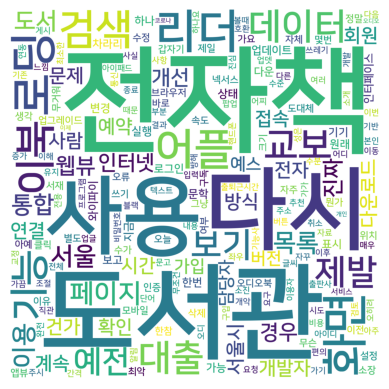

In [94]:
# 폰트
font_path = path = '/usr/share/fonts/truetype/nanum/NanumSquareB.ttf'  # Replace with the path to your font file

#워드클라우스 설정
wc = WordCloud(font_path=font_path, width=800, height=800, scale=2.0, max_font_size=250,background_color='white')
gen = wc.generate_from_frequencies(c)

plt.figure()
plt.imshow(gen)
plt.axis('off')
plt.show()

wc.to_file('서울도서관 워드클라우드.png')